In [17]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 10
nifty50 = pd.read_csv('https://www1.nseindia.com/content/indices/ind_nifty50list.csv')

In [18]:
tickers = [x + '.NS' for x in list(nifty50['Symbol'])]

In [19]:
nifty50 = list()
from pandas_datareader import data

# Only get the adjusted close.
nifty = data.DataReader(tickers, 
                       start='2016-1-1', 
                       end='2020-04-27', 
                       data_source='yahoo')['Adj Close']


In [20]:
# Convert the adjusted closing prices to cumulative returns.
# returns = aapl.pct_change()


NSEI = data.DataReader('^NSEI', 
                       start='2016-1-1', 
                       end='2020-04-27', 
                       data_source='yahoo')['Adj Close']

In [21]:
NSEI = NSEI.reset_index()

In [22]:
NSEI['Date'] = NSEI['Date'].dt.strftime('%Y-%m-%d')

In [23]:
NSEI_roll_std = NSEI.rolling(22).std()

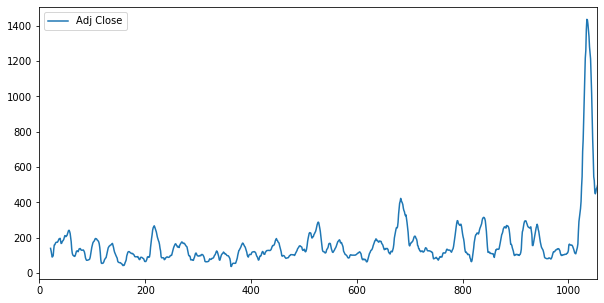

In [24]:
NSEI_roll_std.plot(figsize=(10,5))

In [25]:
nifty = nifty.dropna()

In [26]:
nifty_cor = nifty.rolling(22).corr().dropna()
nifty_cor = nifty_cor.reset_index()

In [27]:
nifty_cor['Date'] = nifty_cor['Date'].dt.strftime('%Y-%m-%d')

# nifty_cor['Date'] = pd.to_datetime(nifty_cor['Date'])

In [28]:
nifty_cor

Symbols,Date,Symbols,ADANIPORTS.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BAJAJFINSV.NS,BPCL.NS,BHARTIARTL.NS,...,TCS.NS,TATAMOTORS.NS,TATASTEEL.NS,TECHM.NS,TITAN.NS,UPL.NS,ULTRACEMCO.NS,VEDL.NS,WIPRO.NS,ZEEL.NS
0,2016-02-02,ADANIPORTS.NS,1.000000,0.429844,0.691459,0.862263,0.533053,0.697443,0.325710,0.932822,...,0.353865,0.898829,0.577489,0.581480,0.075955,0.554275,0.078606,0.887161,-0.234610,0.689747
1,2016-02-02,ASIANPAINT.NS,0.429844,1.000000,0.402840,0.725509,0.628844,0.515685,0.407357,0.295765,...,0.510057,0.395403,0.512762,0.139626,0.432503,0.691218,0.384640,0.608357,0.323172,0.732740
2,2016-02-02,AXISBANK.NS,0.691459,0.402840,1.000000,0.737943,0.462904,0.574808,-0.179829,0.548807,...,0.506727,0.627011,0.826952,0.325522,0.488536,0.643107,0.550381,0.564263,0.140952,0.551697
3,2016-02-02,BAJAJ-AUTO.NS,0.862263,0.725509,0.737943,1.000000,0.615454,0.666576,0.353246,0.760505,...,0.564046,0.790934,0.662695,0.359043,0.367133,0.739661,0.365552,0.858143,0.101586,0.841403
4,2016-02-02,BAJFINANCE.NS,0.533053,0.628844,0.462904,0.615454,1.000000,0.825340,0.274046,0.547939,...,0.477538,0.487887,0.468636,0.216674,0.338061,0.669367,0.199514,0.722355,-0.034129,0.667907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51945,2020-04-27,UPL.NS,0.908528,0.861860,0.916069,0.803807,-0.402273,0.231742,0.843036,0.875925,...,0.553278,0.781361,0.324313,0.222344,0.772708,1.000000,0.866994,0.824845,0.327873,0.656313
51946,2020-04-27,ULTRACEMCO.NS,0.796118,0.774697,0.890733,0.822228,-0.273243,0.226536,0.839781,0.922843,...,0.388047,0.832240,0.603762,0.213451,0.704121,0.866994,1.000000,0.922829,0.259580,0.636250
51947,2020-04-27,VEDL.NS,0.769533,0.819903,0.903721,0.904890,-0.378074,0.109821,0.868653,0.913973,...,0.357380,0.874188,0.498601,0.010226,0.602465,0.824845,0.922829,1.000000,0.130598,0.700303
51948,2020-04-27,WIPRO.NS,0.174721,0.063130,0.355344,0.247971,0.066653,0.042067,0.345539,0.248555,...,0.156278,0.032999,0.222098,0.764274,0.670110,0.327873,0.259580,0.130598,1.000000,0.194829


In [29]:
nifty_cor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51950 entries, 0 to 51949
Data columns (total 52 columns):
Date             51950 non-null object
Symbols          51950 non-null object
ADANIPORTS.NS    51950 non-null float64
ASIANPAINT.NS    51950 non-null float64
AXISBANK.NS      51950 non-null float64
BAJAJ-AUTO.NS    51950 non-null float64
BAJFINANCE.NS    51950 non-null float64
BAJAJFINSV.NS    51950 non-null float64
BPCL.NS          51950 non-null float64
BHARTIARTL.NS    51950 non-null float64
INFRATEL.NS      51950 non-null float64
BRITANNIA.NS     51950 non-null float64
CIPLA.NS         51950 non-null float64
COALINDIA.NS     51950 non-null float64
DRREDDY.NS       51950 non-null float64
EICHERMOT.NS     51950 non-null float64
GAIL.NS          51950 non-null float64
GRASIM.NS        51950 non-null float64
HCLTECH.NS       51950 non-null float64
HDFCBANK.NS      51950 non-null float64
HEROMOTOCO.NS    51950 non-null float64
HINDALCO.NS      51950 non-null float64
HINDUNILVR.NS

In [30]:
nifty_cor[nifty_cor['Date']=='2016-02-02'].to_numpy().shape

(50, 52)

In [31]:
import networkx as nx

G = {}
avg_clustering_df = pd.DataFrame(columns = ['Date','Clustering'])

for date in list(nifty_cor['Date'].unique()):
    graph_df = nifty_cor[nifty_cor['Date']==date].drop(['Date','Symbols'], axis=1).to_numpy()
    G[date] = nx.from_numpy_matrix(graph_df,
                                  parallel_edges=False)
    temp = nx.average_clustering(G[date], weight = 'weight')
    
    avg_clustering_coef = pd.DataFrame({'Date': [date],
                                        'Clustering': [temp]})
    
    avg_clustering_df = pd.concat([avg_clustering_df,avg_clustering_coef], sort=False)


In [32]:
avg_clustering_df['Absolute'] =  avg_clustering_df['Clustering'].abs()



In [33]:
# avg_clustering_df = avg_clustering_df.set_index('Date')
avg_clustering_df = avg_clustering_df.reset_index()

In [34]:
avg_clustering_df = pd.merge(avg_clustering_df, NSEI, on = 'Date')

In [35]:
avg_clustering_df.columns

Index(['index', 'Date', 'Clustering', 'Absolute', 'Adj Close'], dtype='object')

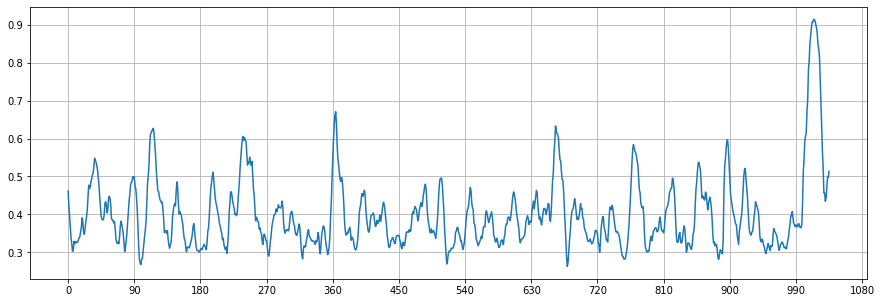

In [36]:
import matplotlib.pyplot as plt


import matplotlib.ticker as plticker


fig, ax = plt.subplots(figsize=(15,5))

ax.plot(avg_clustering_df['Absolute'])

loc = plticker.MultipleLocator(base= 90) # this locator puts ticks at regular intervals

ax.xaxis.set_major_locator(loc)

plt.grid(True)
plt.show()

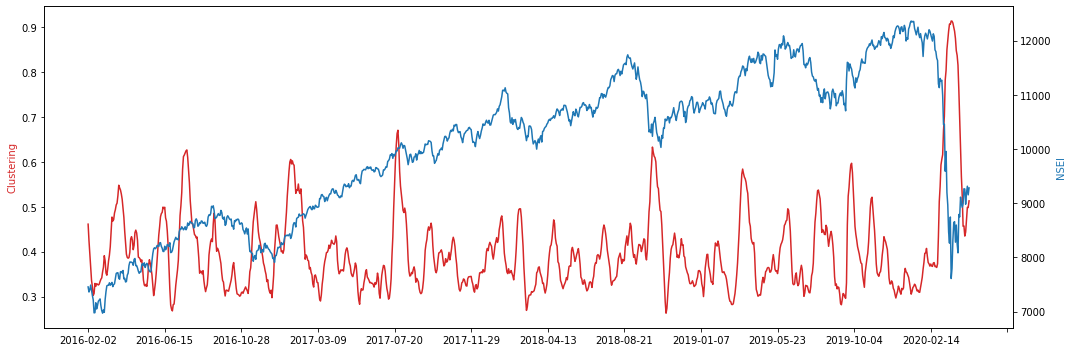

In [37]:
fig, ax1 = plt.subplots(figsize=(15,5))

color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('Clustering', color=color)
ax1.plot(avg_clustering_df['Date'], avg_clustering_df['Absolute'], color=color)
# ax1.tick_params(axis='y', labelcolor=color)
loc = plticker.MultipleLocator(base= 90) # this locator puts ticks at regular intervals

ax1.xaxis.set_major_locator(loc)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('NSEI', color=color)  # we already handled the x-label with ax1
ax2.plot(avg_clustering_df['Date'], avg_clustering_df['Adj Close'], color=color)

# ax2.tick_params(axis='y', labelcolor=color)

loc = plticker.MultipleLocator(base= 90) # this locator puts ticks at regular intervals

ax2.xaxis.set_major_locator(loc)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

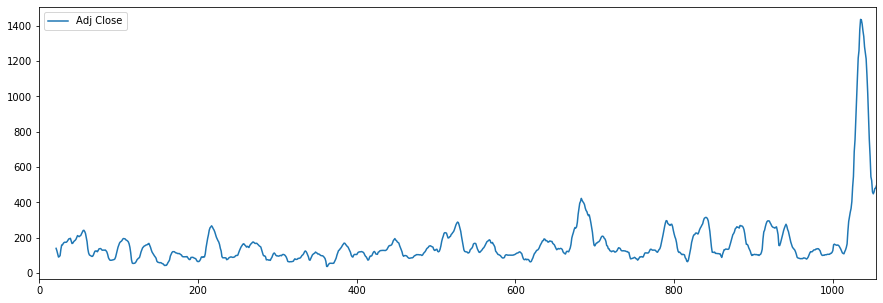

In [38]:
NSEI_roll_std.plot(figsize=(15,5))